In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [31]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled2.csv")
df.head(10)

,question_id,answer,grade
0,2,نزل ميكائيل عليه السلام على الرسول في أول وحي ...,0
1,2,في عتمة الغار، تلقى الرسول نفحاتِ الوحي، كلمات...,1
2,2,في غارِ حراء، ظهر للرسول ملاكٌ يُغيّرُ مجرىَ ا...,1
3,2,من وراء حجاب النور، تكلّم ملاكٌ بكلام الله، فح...,1
4,2,في رحلةٍ من التأمل والعزلة، اختصَ اللهُ عزَّ و...,2
5,2,عهدٍ إلهيٍ محمولٍ على أجنحة الملائكة، تلقى الر...,1
6,2,ظهر للرسول في أول وحي له نوح عليه السلام.,0
7,2,ظهر ميكائيل للنبي محمد في الوحي الأول.,0
8,2,لحظةٌ مقدسة، نورٌ يهبطُ من عليٍ، ملاكٌ يحملُ أ...,1
9,2,ظهر جبريل عليه السلام للنبي محمد في الوحي الأول.,2


*<h3>EDA<h3>*

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  90 non-null     int64 
 1   answer       90 non-null     object
 2   grade        90 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ KB


In [33]:
df.groupby('grade').size()

grade
0    29
1    28
2    33
dtype: int64

In [34]:
df.duplicated().sum()

0

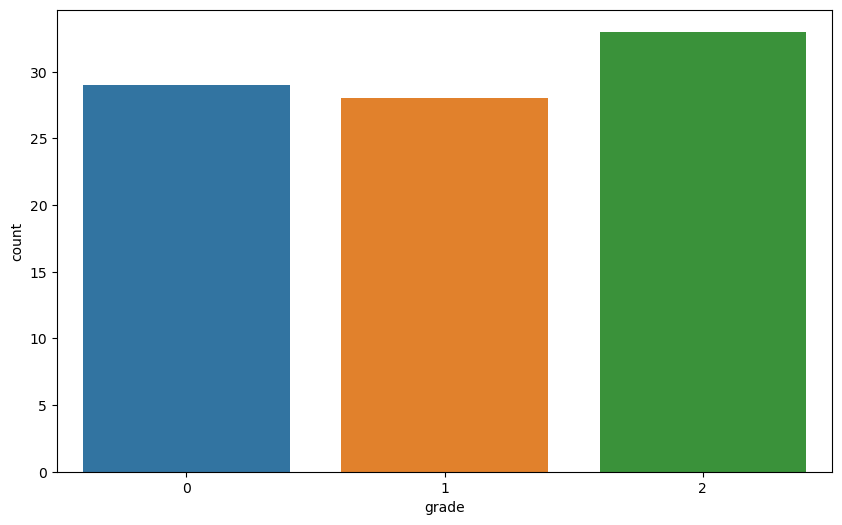

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [36]:
df.drop('question_id', axis=1, inplace=True)

In [37]:
df.dropna(inplace=True)

In [38]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0     نزل ميكائيل عليه السلام على الرسول في أول وحي ...
1     في عتمة الغار، تلقى الرسول نفحاتِ الوحي، كلمات...
2     في غارِ حراء، ظهر للرسول ملاكٌ يُغيّرُ مجرىَ ا...
3     من وراء حجاب النور، تكلّم ملاكٌ بكلام الله، فح...
4     في رحلةٍ من التأمل والعزلة، اختصَ اللهُ عزَّ و...
                            ...                        
85    مع نزول جبريل عليه السلام على الرسول في أول وح...
86               ظهر إسرافيل للنبي محمد في الوحي الأول.
87        أوصل أحد الملائكة رسالة الله تعالى إلى الرسول
88                            الملاك جبريل عليه السلام 
89    في ليلة القدر، ظهر للرسول في أول وحي له جبريل ...
Name: answer, Length: 90, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [39]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 22:25:02 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 22:25:03 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 22:25:07 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 22:25:07 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 22:25:09 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 22:25:09 INFO: Using device: cpu
2024-01-09 22:25:09 INFO: Loading: tokenize
2024-01-09 22:25:09 INFO: Loading: mwt
2024-01-09 22:25:09 INFO: Loading: pos
2024-01-09 22:25:10 INFO: Loading: lemma
2024-01-09 22:25:10 INFO: Loading: depparse
2024-01-09 22:25:10 INFO: Loading: ner
2024-01-09 22:25:11 INFO: Done loading processors!


In [40]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[  0   0   0 ...  69 101  46]
 [  0   0   0 ...   3 107  70]
 [  0   0   0 ... 109 110 111]
 ...
 [  0   0   0 ...  37  35   7]
 [  0   0   0 ...   3   1   6]
 [  0   0   0 ...   1  10  15]]
0     [نَزَل, مِيكَائِيل, عَلَى, هُوَ, سَلَام, عَلَى...
1     [فِي, عتمة, غَار, تَلَقَّى, رَسُول, نفحاتِ, وَ...
2     [فِي, غارِ, حراء, ظَهَر, لِ, رَسُول, ملاكٌ, أَ...
3     [مِن, وَرَاءَ, حِجَاب, النور, كَلَّم, ملاكٌ, ب...
4     [فِي, رِحلَة, ٍِ, مِن, تَأَمُّل, وَ, عُزلَة, ا...
                            ...                        
85    [مَعَ, نُزُول, جبريل, عَلَى, هُوَ, سَلَام, عَل...
86    [ظَهَر, إسرافيل, لِ, نَبِيّ, محمد, فِي, وَحي, ...
87    [أَوصَل, أَحَد, مَلأَك, رِسَالَة, اَللّٰه, تَع...
88                 [مَالِك, جبريل, عَلَى, هُوَ, سَلَام]
89    [فِي, لَيلَة, قَدر, ظَهَر, لِ, رَسُول, فِي, أَ...
Name: answer, Length: 90, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")

Epoch 1/100
2/2 [==============================] - 4s 594ms/step - loss: 1.3454 - accuracy: 0.3194 - val_loss: 1.2022 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 1.2001 - accuracy: 0.3750 - val_loss: 1.1753 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 1.2602 - accuracy: 0.3611 - val_loss: 1.1857 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 1.2513 - accuracy: 0.4375
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/2 [==============================] - 0s 54ms/step - loss: 1.2318 - accuracy: 0.4583 - val_loss: 1.1960 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 1.1600 - accuracy: 0.4861 - val_loss: 1.1995 - val_accuracy: 0.2778 - lr: 2.0000e-04
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 1.148

*<h4>LSTM Model<h4>*

In [42]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
2/2 [==============================] - 6s 835ms/step - loss: 1.1993 - accuracy: 0.2778 - val_loss: 1.1975 - val_accuracy: 0.4444
Epoch 2/100
2/2 [==============================] - 0s 106ms/step - loss: 1.1639 - accuracy: 0.5833 - val_loss: 1.1946 - val_accuracy: 0.3889
Epoch 3/100
2/2 [==============================] - 0s 86ms/step - loss: 1.1198 - accuracy: 0.6944 - val_loss: 1.1911 - val_accuracy: 0.6111
Epoch 4/100
2/2 [==============================] - 0s 82ms/step - loss: 1.0427 - accuracy: 0.7778 - val_loss: 1.1878 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 0s 81ms/step - loss: 0.9532 - accuracy: 0.6667 - val_loss: 1.1823 - val_accuracy: 0.6667
Epoch 6/100
2/2 [==============================] - 0s 97ms/step - loss: 0.8070 - accuracy: 0.7500 - val_loss: 1.1745 - val_accuracy: 0.6667
Epoch 7/100
2/2 [==============================] - 0s 115ms/step - loss: 0.6941 - accuracy: 0.7917 - val_loss: 1.1663 - val_accuracy: 0.6667
Epoch 8/100
2/2 [

*<h4>TRANSFORMER Model<h4>*

In [43]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [44]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [45]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/30
3/3 [==============================] - 12s 604ms/step - loss: 1.8518 - accuracy: 0.2368 - val_loss: 1.8231 - val_accuracy: 0.2857
Epoch 2/30
3/3 [==============================] - 0s 80ms/step - loss: 1.6921 - accuracy: 0.3421 - val_loss: 1.6051 - val_accuracy: 0.3571
Epoch 3/30
3/3 [==============================] - 0s 80ms/step - loss: 1.7026 - accuracy: 0.3553 - val_loss: 1.5282 - val_accuracy: 0.4286
Epoch 4/30
3/3 [==============================] - 0s 81ms/step - loss: 1.6155 - accuracy: 0.3158 - val_loss: 1.5552 - val_accuracy: 0.3571
Epoch 5/30
3/3 [==============================] - 0s 78ms/step - loss: 1.5776 - accuracy: 0.3684 - val_loss: 1.5288 - val_accuracy: 0.4286
Epoch 6/30
3/3 [==============================] - 0s 84ms/step - loss: 1.5036 - accuracy: 0.4868 - val_loss: 1.4804 - val_accuracy: 0.3571
Epoch 7/30
3/3 [==============================] - 0s 81ms/step - loss: 1.4267 - accuracy: 0.4211 - val_loss: 1.3777 - val_accuracy: 0.4286
Epoch 8/30
3/3 [=========

In [46]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 45ms/step - loss: 0.4849 - accuracy: 0.8571
Evaluation Metrics Transformer:
loss: 0.4848890006542206
accuracy: 0.8571428656578064


In [47]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 1s 877ms/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 160  23   3   1   6   3   7  36   3  61   1 161  15]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  10 144 145  78  23   3   1   6   3   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  28   8  52  31  30  12   9   2   7  33  45  10 186 187   3 188]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  95
   13   3   1   6   2   7   4   8   5  11   2   1   2 202   2 203 204  56]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19
   18   3   1   6   3   7   4   8   5  11   2   1   2 100   1  69 101  46]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  45  18   3   1   6   7   4   8   5  11   2   1 150  34   1  84]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0

In [48]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.6428571343421936
Accuracy LSTM: 0.9285714030265808
Accuracy Transformer: 0.8571428656578064


In [49]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q2_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (LSTM) with accuracy 0.9285714030265808 has been saved to './savedModels/q2_model.h5'
